# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [1]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [2]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [3]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded MNIST: {len(train_dataset)} train samples, {len(val_dataset)} val samples")

Loaded MNIST: 48000 train samples, 12000 val samples


In [4]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:

if not torch.cuda.is_available():
    raise EnvironmentError("❌ GPU is not available. Please enable GPU in Colab (Runtime > Change runtime type > GPU).")

gpu_props = torch.cuda.get_device_properties(0)
total_mem_gb = gpu_props.total_memory / (1024 ** 3)

print(f"GPU detected: {gpu_props.name}")
print(f"Total GPU memory: {total_mem_gb:.2f} GB")

required_memory_gb = 2.0
if total_mem_gb < required_memory_gb:
    raise MemoryError(f"❌ Not enough GPU memory. At least {required_memory_gb} GB is recommended.")
else:
    print(f"Sufficient GPU memory for MNIST (needs ~{required_memory_gb} GB)")


GPU detected: Tesla T4
Total GPU memory: 14.74 GB
Sufficient GPU memory for MNIST (needs ~2.0 GB)


In [5]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:

sample_loader = DataLoader(dataset, batch_size=1)
sample_image, sample_label = next(iter(sample_loader))

print("Sample image shape:", sample_image.shape)
print("Sample label:", sample_label.item())
print("Image pixel range: min =", sample_image.min().item(), ", max =", sample_image.max().item())
print("Image dtype:", sample_image.dtype)

#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:

from torch.utils.data import DataLoader
import multiprocessing

num_workers = min(4, multiprocessing.cpu_count())  # Safe choice for Colab

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("DataLoaders are ready")


Sample image shape: torch.Size([1, 1, 28, 28])
Sample label: 5
Image pixel range: min = -1.0 , max = 1.0
Image dtype: torch.float32
Training samples: 48000
Validation samples: 12000
DataLoaders are ready


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [6]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:

        return self.block(x)

In [7]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:

        self.rearrange = Rearrange('b c (h2 h) (w2 w) -> b (c h2 w2) h w', h2=2, w2=2)
        self.conv = GELUConvBlock(in_chs * 4, in_chs, group_size)

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        x = self.rearrange(x)
        x = self.conv(x)
        return x

In [8]:
#Let's implement the upsampling block for our U-Net architecture:
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Provides the output *before* downsampling as the skip connection
    3. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)
        self.pool = RearrangePoolBlock(out_chs, group_size) # Pool the output of conv2

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            tuple: (downsampled_output, skip_connection)
                - downsampled_output is the tensor after pooling [B, out_chs, H/2, W/2]
                - skip_connection is the tensor before pooling [B, out_chs, H, W]
        """
        x = self.conv1(x)
        x = self.conv2(x)
        skip = x # Skip connection is the output before pooling
        x = self.pool(x) # Pool the main path
        return x, skip # Return both downsampled features and the pre-pooled skip

In [9]:
#Now let's implement the upsampling block for our U-Net architecture:

class UpBlock(nn.Module):
    def __init__(self, in_chs, skip_chs, out_chs, group_size=4):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = GELUConvBlock(in_chs + skip_chs, out_chs, group_size)

    def forward(self, x, skip):
        x = self.upsample(x)
        # Resize skip connection if spatial sizes don't match
        if x.shape[-1] != skip.shape[-1] or x.shape[-2] != skip.shape[-2]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode="nearest")
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [10]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [29]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
        )

    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        x = self.model(x)
        # Reshape for broadcasting with feature maps
        return x.unsqueeze(-1).unsqueeze(-1)

In [43]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.
    This model takes a noisy image, a time step, and a class label,
    and it predicts the noise that was added to the image.
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Time embedding MLP
        # CORRECTED: Removed the nn.Unflatten layer. The MLP now correctly
        # outputs a tensor of shape [batch_size, t_embed_dim].
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding MLP (uses the corrected EmbedBlock from previous steps)
        self.class_mlp = EmbedBlock(input_dim=c_embed_dim, emb_dim=t_embed_dim)

        # Initial convolution to increase the image's channel dimension
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], group_size=4)

        # Downsampling path of the U-Net
        self.down_blocks = nn.ModuleList([
            DownBlock(down_chs[i], down_chs[i + 1], group_size=4)
            for i in range(len(down_chs) - 1)
        ])

        # Middle blocks at the bottleneck of the U-Net
        mid_ch = down_chs[-1]
        self.middle_blocks = nn.Sequential(
            GELUConvBlock(mid_ch, mid_ch, group_size=4),
            GELUConvBlock(mid_ch, mid_ch, group_size=4)
        )

        # Upsampling path of the U-Net
        self.up_blocks = nn.ModuleList()
        for i in range(len(down_chs) - 1, 0, -1):
            self.up_blocks.append(UpBlock(
                in_chs=down_chs[i],
                skip_chs=down_chs[i],
                out_chs=down_chs[i - 1],
                group_size=4
            ))

        # Final convolution to project back to the original image channels
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.
        """
        # 1. Compute time and class embeddings
        t_embed = self.time_mlp(t)  # Output shape: [B, D]
        c_embed = self.class_mlp(c)  # Output shape: [B, D, 1, 1]

        # 2. Apply conditioning mask for classifier-free guidance
        # This allows us to "turn off" the class conditioning during inference if needed.
        # The mask is reshaped to broadcast correctly with the embedding tensor.
        c_embed = c_embed * c_mask.view(-1, 1, 1, 1)

        # 3. Initial convolution
        x = self.init_conv(x)
        skips = []

        # 4. Downsampling path
        for down in self.down_blocks:
            x, skip = down(x)
            skips.append(skip)

        # 5. Middle blocks (bottleneck)
        x = self.middle_blocks(x)

        # 6. **FIX**: Add time and class embeddings at the bottleneck.
        # The time embedding is reshaped to [B, D, 1, 1] so it can be added to
        # the feature map `x` [B, C, H, W] via broadcasting.
        x = x + t_embed.unsqueeze(-1).unsqueeze(-1) + c_embed

        # 7. Upsampling path
        for i, up in enumerate(self.up_blocks):
            skip_index = len(skips) - 1 - i
            skip = skips[skip_index]
            x = up(x, skip)

        # 8. Final convolution
        out = self.final_conv(x)
        return out

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [13]:
# Set up the noise schedule
n_steps = 100  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise


In [14]:

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)     # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [31]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.
    ... (rest of docstring)
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    # FIX: Define the missing variable from the global noise schedule
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise


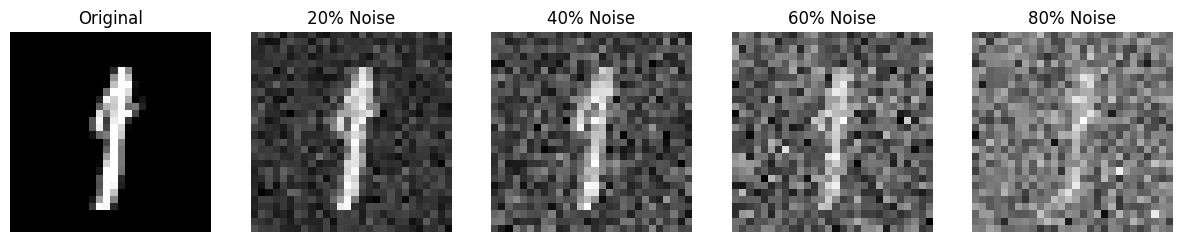

In [16]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/num_steps) * 100)}% Noise')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_loader))  # Get first batch
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [44]:
# Define channel dimensions for each downsampling level
down_chs = (32, 64, 128)

# Define group size for GroupNorm
group_size = 4 # You can adjust this based on experiments

# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=down_chs,         # Channel dimensions for each downsampling level
    t_embed_dim=down_chs[-1],  # Dimension for time step embeddings (match middle block channels)
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_model_memory(model, img_size=(IMG_CH, IMG_SIZE, IMG_SIZE)):
    dummy_input = torch.randn(1, *img_size).to(device)
    t_dummy = torch.randint(0, n_steps, (1,), device=device)
    c_dummy = torch.zeros((1, N_CLASSES), device=device)
    c_mask_dummy = torch.ones((1, 1), device=device)
    with torch.no_grad():
        torch.cuda.reset_peak_memory_stats()
        _ = model(dummy_input, t_dummy, c_dummy, c_mask_dummy)
        mem = torch.cuda.max_memory_allocated(device=device) / 1e6 if torch.cuda.is_available() else 0
    return mem

print(f"Trainable parameters: {count_params(model):,}")
print(f"Approx. memory use during 1 forward pass: {estimate_model_memory(model):.2f} MB")

# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:

def check_data_ranges(dataloader, name=""):
    for images, _ in dataloader:
        print(f"\n{name} Data Check:")
        print(f"- Min: {images.min().item():.4f}")
        print(f"- Max: {images.max().item():.4f}")
        print(f"- Mean: {images.mean().item():.4f}")
        print(f"- Std: {images.std().item():.4f}")
        break

check_data_ranges(train_loader, "Train") # Fixed: train_dataloader -> train_loader
check_data_ranges(val_loader, "Val") # Fixed: val_dataloader -> val_loader


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
Created DownBlock: in_chs=64, out_chs=128, spatial_reduction=2x
Created UNet with 3 scale levels
Channel dimensions: (32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Trainable parameters: 1,547,137
Approx. memory use during 1 forward pass: 28.15 MB

Train Data Check:
- Min: -1.0000
- Max: 1.0000
- Mean: -0.7418
- Std: 0.6084

Val Data Check:
- Min: -1.0000
- Max: 1.0000
- Mean: -0.7314
- Std: 0.6240


In [23]:
# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

In [24]:
#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    # Example: Label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] for MNIST
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:

    x_t, noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:

    loss = F.mse_loss(predicted_noise, noise)

    return loss



STARTING TRAINING

Epoch 1/30
--------------------
  Step 0/750, Loss: 1.0843
  Step 100/750, Loss: 0.1031
  Step 200/750, Loss: 0.1034
  Step 300/750, Loss: 0.0908
  Step 400/750, Loss: 0.0921
  Step 500/750, Loss: 0.0682
  Generating samples...


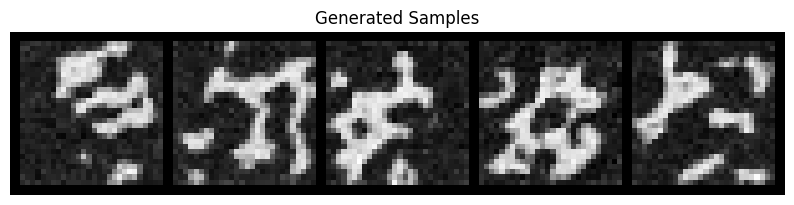

  Step 600/750, Loss: 0.0874
  Step 700/750, Loss: 0.0702

Training - Epoch 1 average loss: 0.0996
Running validation...
Validation - Epoch 1 average loss: 0.0735
Current learning rate: 0.001000

Generating samples for visual progress check...


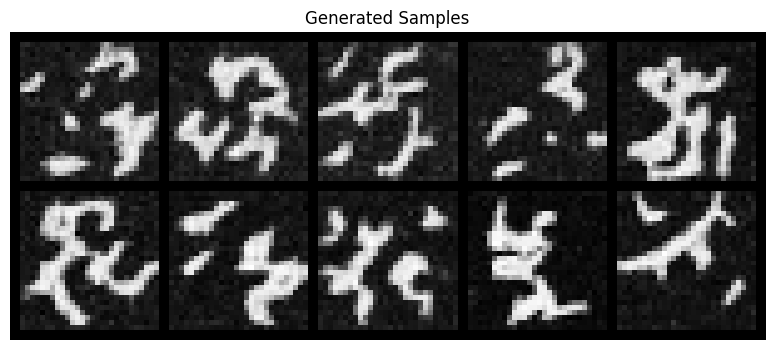

Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0735)


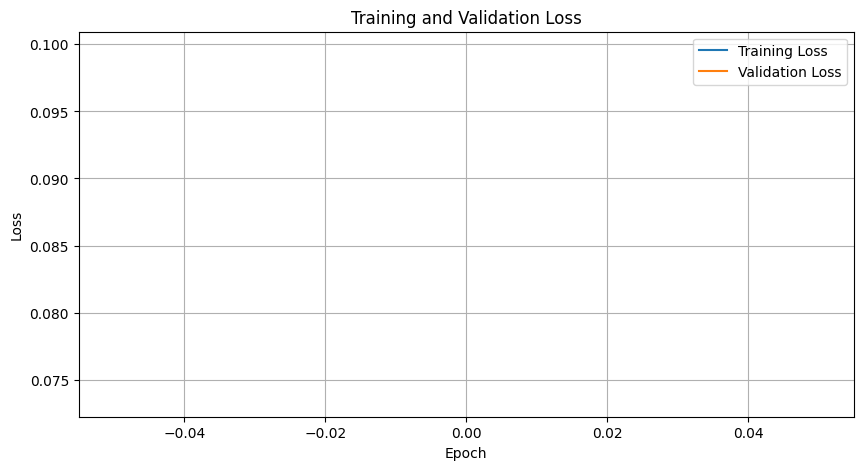


Epoch 2/30
--------------------
  Step 0/750, Loss: 0.0748
  Step 100/750, Loss: 0.0672
  Step 200/750, Loss: 0.0724
  Step 300/750, Loss: 0.0727
  Step 400/750, Loss: 0.0637
  Step 500/750, Loss: 0.0755
  Generating samples...


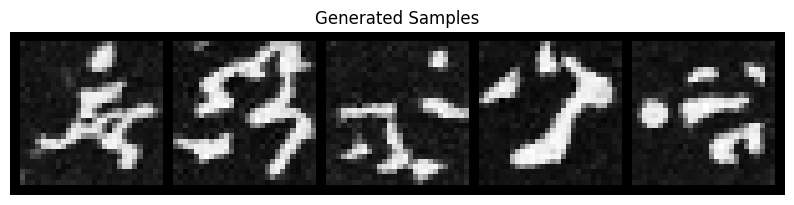

  Step 600/750, Loss: 0.0663
  Step 700/750, Loss: 0.0722

Training - Epoch 2 average loss: 0.0718
Running validation...
Validation - Epoch 2 average loss: 0.0694
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0694)

Epoch 3/30
--------------------
  Step 0/750, Loss: 0.0617
  Step 100/750, Loss: 0.0687
  Step 200/750, Loss: 0.0737
  Step 300/750, Loss: 0.0634
  Step 400/750, Loss: 0.0589
  Step 500/750, Loss: 0.0726
  Generating samples...


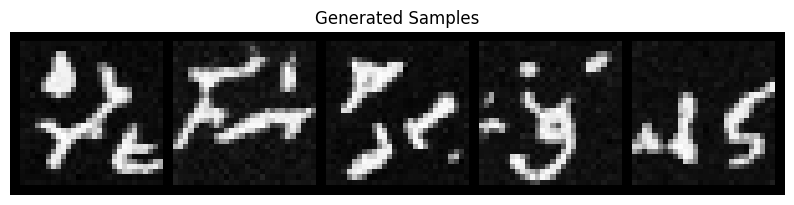

  Step 600/750, Loss: 0.0713
  Step 700/750, Loss: 0.0674

Training - Epoch 3 average loss: 0.0689
Running validation...
Validation - Epoch 3 average loss: 0.0665
Current learning rate: 0.001000

Generating samples for visual progress check...


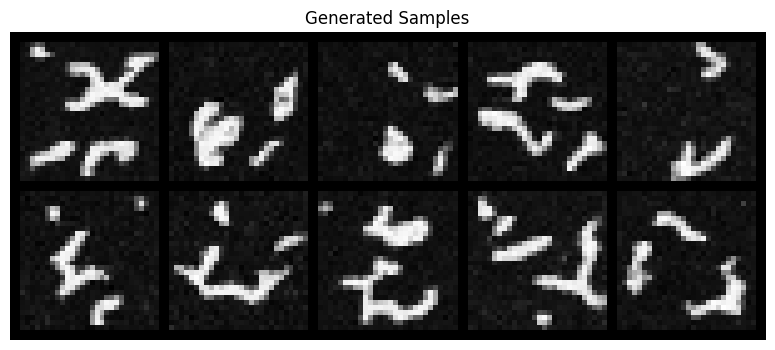

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0665)

Epoch 4/30
--------------------
  Step 0/750, Loss: 0.0736
  Step 100/750, Loss: 0.0705
  Step 200/750, Loss: 0.0758
  Step 300/750, Loss: 0.0758
  Step 400/750, Loss: 0.0620
  Step 500/750, Loss: 0.0612
  Generating samples...


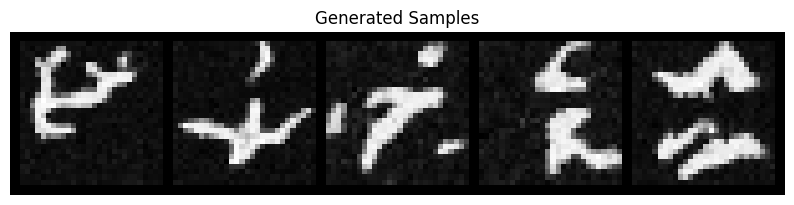

  Step 600/750, Loss: 0.0637
  Step 700/750, Loss: 0.0641

Training - Epoch 4 average loss: 0.0667
Running validation...
Validation - Epoch 4 average loss: 0.0673
Current learning rate: 0.001000
No improvement for 1/10 epochs.

Epoch 5/30
--------------------
  Step 0/750, Loss: 0.0633
  Step 100/750, Loss: 0.0605
  Step 200/750, Loss: 0.0733
  Step 300/750, Loss: 0.0590
  Step 400/750, Loss: 0.0647
  Step 500/750, Loss: 0.0674
  Generating samples...


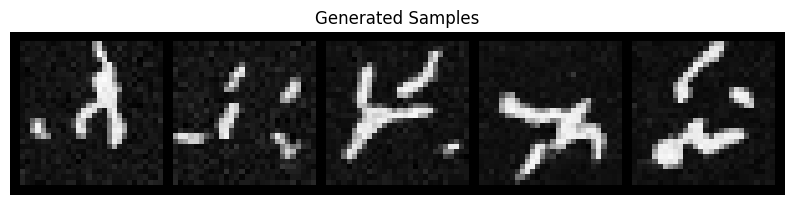

  Step 600/750, Loss: 0.0627
  Step 700/750, Loss: 0.0620

Training - Epoch 5 average loss: 0.0658
Running validation...
Validation - Epoch 5 average loss: 0.0641
Current learning rate: 0.001000

Generating samples for visual progress check...


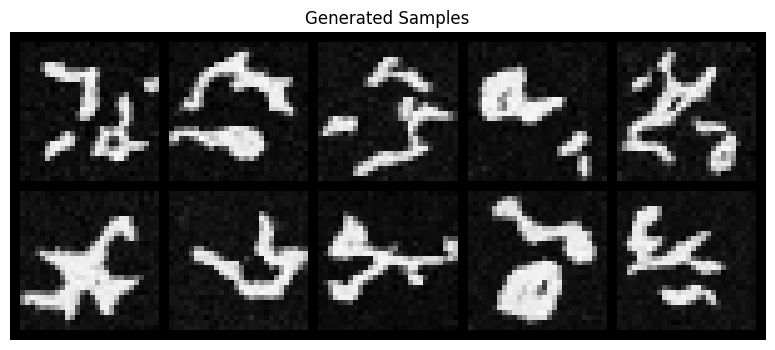

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0641)

Epoch 6/30
--------------------
  Step 0/750, Loss: 0.0601
  Step 100/750, Loss: 0.0630
  Step 200/750, Loss: 0.0632
  Step 300/750, Loss: 0.0722
  Step 400/750, Loss: 0.0591
  Step 500/750, Loss: 0.0645
  Generating samples...


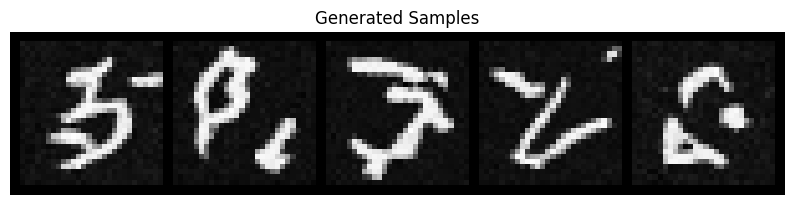

  Step 600/750, Loss: 0.0667
  Step 700/750, Loss: 0.0614

Training - Epoch 6 average loss: 0.0645
Running validation...
Validation - Epoch 6 average loss: 0.0643
Current learning rate: 0.001000
No improvement for 1/10 epochs.


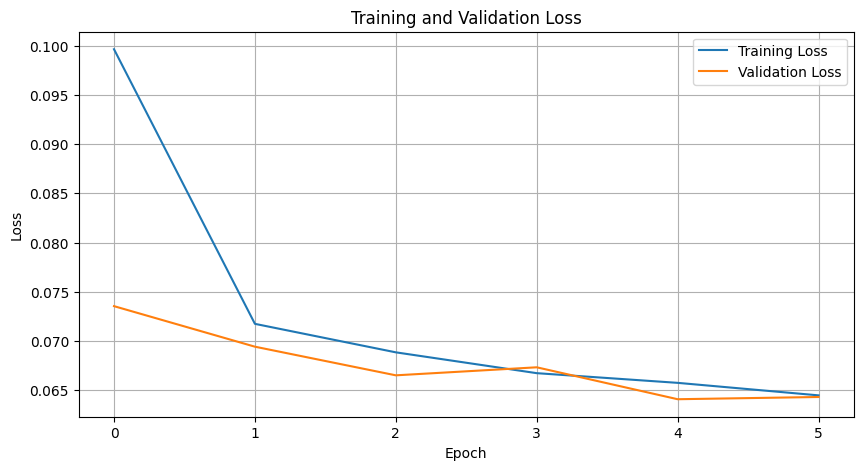


Epoch 7/30
--------------------
  Step 0/750, Loss: 0.0690
  Step 100/750, Loss: 0.0702
  Step 200/750, Loss: 0.0591
  Step 300/750, Loss: 0.0661
  Step 400/750, Loss: 0.0621
  Step 500/750, Loss: 0.0602
  Generating samples...


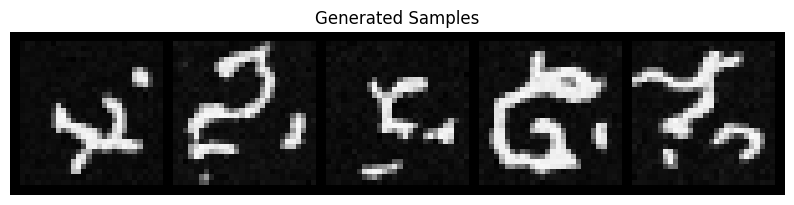

  Step 600/750, Loss: 0.0640
  Step 700/750, Loss: 0.0685

Training - Epoch 7 average loss: 0.0641
Running validation...
Validation - Epoch 7 average loss: 0.0654
Current learning rate: 0.001000

Generating samples for visual progress check...


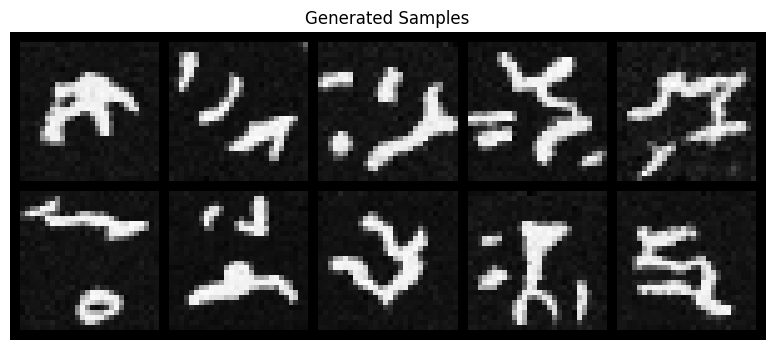

No improvement for 2/10 epochs.

Epoch 8/30
--------------------
  Step 0/750, Loss: 0.0700
  Step 100/750, Loss: 0.0672
  Step 200/750, Loss: 0.0625
  Step 300/750, Loss: 0.0677
  Step 400/750, Loss: 0.0697
  Step 500/750, Loss: 0.0643
  Generating samples...


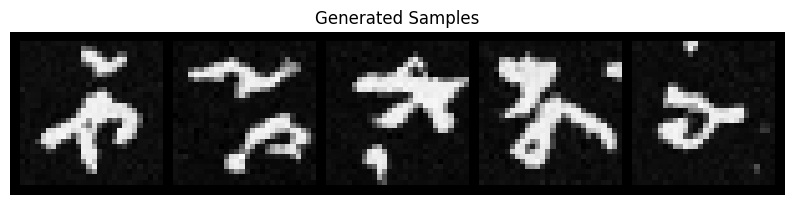

  Step 600/750, Loss: 0.0651
  Step 700/750, Loss: 0.0609

Training - Epoch 8 average loss: 0.0632
Running validation...
Validation - Epoch 8 average loss: 0.0632
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0632)

Epoch 9/30
--------------------
  Step 0/750, Loss: 0.0592
  Step 100/750, Loss: 0.0628
  Step 200/750, Loss: 0.0599
  Step 300/750, Loss: 0.0794
  Step 400/750, Loss: 0.0534
  Step 500/750, Loss: 0.0676
  Generating samples...


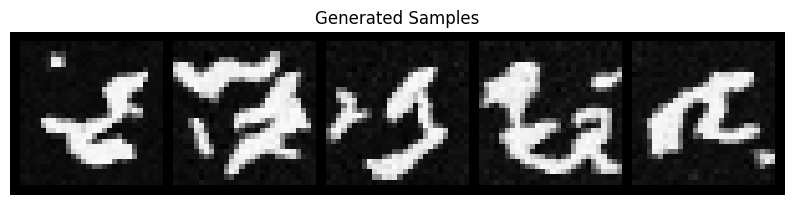

  Step 600/750, Loss: 0.0647
  Step 700/750, Loss: 0.0568

Training - Epoch 9 average loss: 0.0631
Running validation...
Validation - Epoch 9 average loss: 0.0624
Current learning rate: 0.001000

Generating samples for visual progress check...


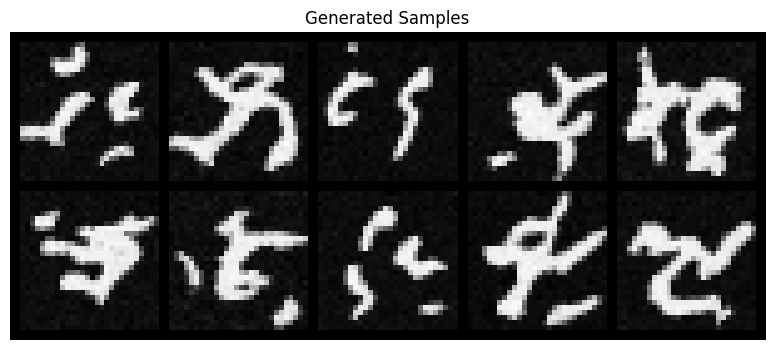

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0624)

Epoch 10/30
--------------------
  Step 0/750, Loss: 0.0568
  Step 100/750, Loss: 0.0576
  Step 200/750, Loss: 0.0592
  Step 300/750, Loss: 0.0618
  Step 400/750, Loss: 0.0608
  Step 500/750, Loss: 0.0697
  Generating samples...


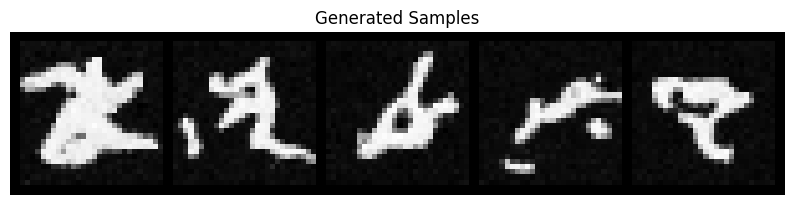

  Step 600/750, Loss: 0.0638
  Step 700/750, Loss: 0.0605

Training - Epoch 10 average loss: 0.0626
Running validation...
Validation - Epoch 10 average loss: 0.0625
Current learning rate: 0.001000
No improvement for 1/10 epochs.

Epoch 11/30
--------------------
  Step 0/750, Loss: 0.0636
  Step 100/750, Loss: 0.0652
  Step 200/750, Loss: 0.0641
  Step 300/750, Loss: 0.0617
  Step 400/750, Loss: 0.0621
  Step 500/750, Loss: 0.0690
  Generating samples...


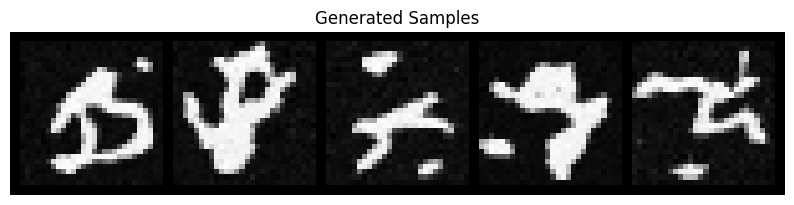

  Step 600/750, Loss: 0.0688
  Step 700/750, Loss: 0.0674

Training - Epoch 11 average loss: 0.0621
Running validation...
Validation - Epoch 11 average loss: 0.0623
Current learning rate: 0.001000

Generating samples for visual progress check...


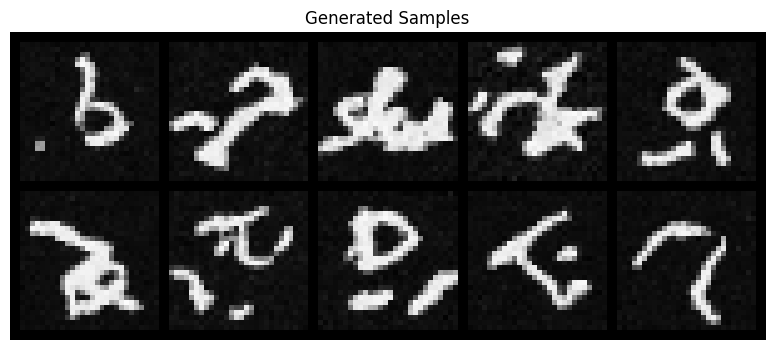

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0623)


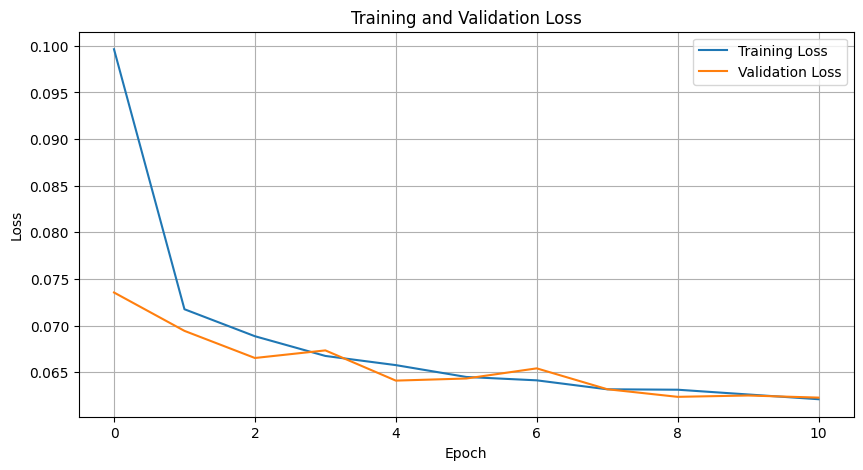


Epoch 12/30
--------------------
  Step 0/750, Loss: 0.0602
  Step 100/750, Loss: 0.0596
  Step 200/750, Loss: 0.0622
  Step 300/750, Loss: 0.0605
  Step 400/750, Loss: 0.0566
  Step 500/750, Loss: 0.0636
  Generating samples...


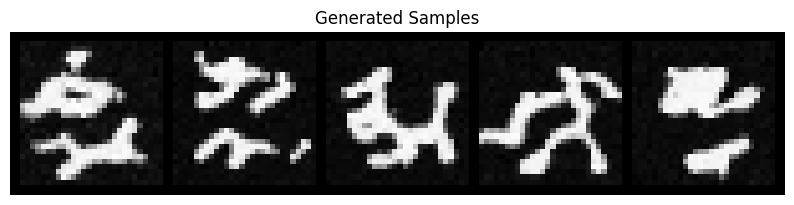

  Step 600/750, Loss: 0.0644
  Step 700/750, Loss: 0.0626

Training - Epoch 12 average loss: 0.0620
Running validation...
Validation - Epoch 12 average loss: 0.0615
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0615)

Epoch 13/30
--------------------
  Step 0/750, Loss: 0.0641
  Step 100/750, Loss: 0.0617
  Step 200/750, Loss: 0.0574
  Step 300/750, Loss: 0.0674
  Step 400/750, Loss: 0.0638
  Step 500/750, Loss: 0.0704
  Generating samples...


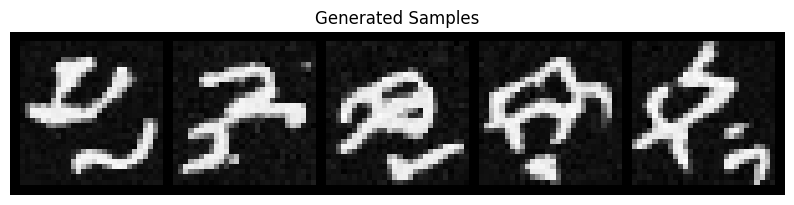

  Step 600/750, Loss: 0.0552
  Step 700/750, Loss: 0.0579

Training - Epoch 13 average loss: 0.0618
Running validation...
Validation - Epoch 13 average loss: 0.0608
Current learning rate: 0.001000

Generating samples for visual progress check...


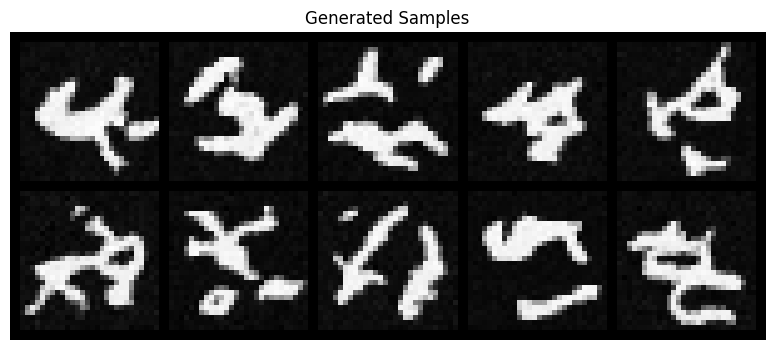

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0608)

Epoch 14/30
--------------------
  Step 0/750, Loss: 0.0588
  Step 100/750, Loss: 0.0652
  Step 200/750, Loss: 0.0612
  Step 300/750, Loss: 0.0581
  Step 400/750, Loss: 0.0660
  Step 500/750, Loss: 0.0585
  Generating samples...


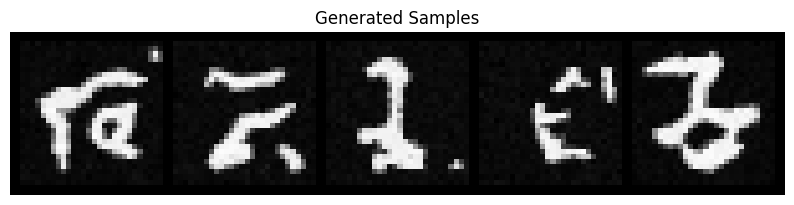

  Step 600/750, Loss: 0.0623
  Step 700/750, Loss: 0.0637

Training - Epoch 14 average loss: 0.0615
Running validation...
Validation - Epoch 14 average loss: 0.0601
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0601)

Epoch 15/30
--------------------
  Step 0/750, Loss: 0.0661
  Step 100/750, Loss: 0.0618
  Step 200/750, Loss: 0.0548
  Step 300/750, Loss: 0.0604
  Step 400/750, Loss: 0.0626
  Step 500/750, Loss: 0.0547
  Generating samples...


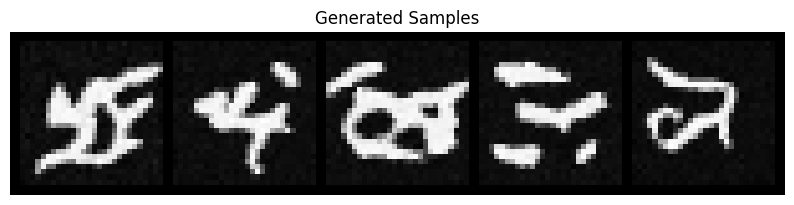

  Step 600/750, Loss: 0.0498
  Step 700/750, Loss: 0.0578

Training - Epoch 15 average loss: 0.0614
Running validation...
Validation - Epoch 15 average loss: 0.0619
Current learning rate: 0.001000

Generating samples for visual progress check...


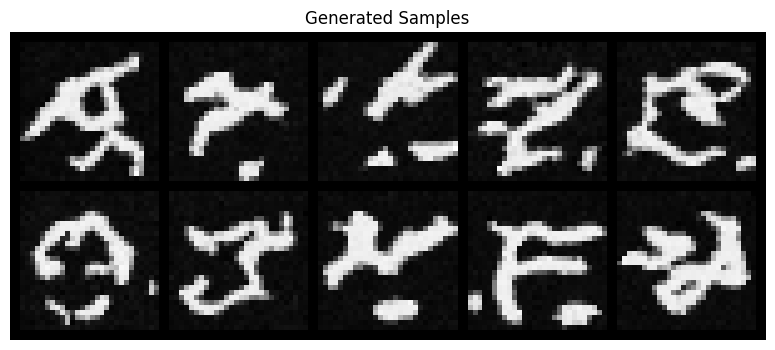

No improvement for 1/10 epochs.

Epoch 16/30
--------------------
  Step 0/750, Loss: 0.0670
  Step 100/750, Loss: 0.0548
  Step 200/750, Loss: 0.0669
  Step 300/750, Loss: 0.0603
  Step 400/750, Loss: 0.0568
  Step 500/750, Loss: 0.0565
  Generating samples...


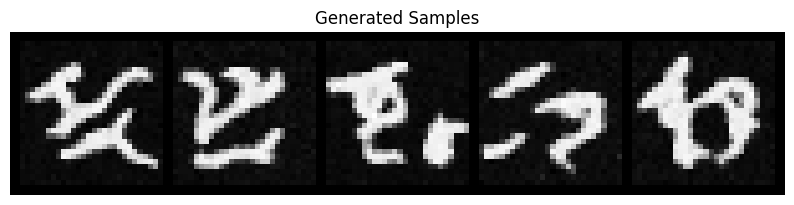

  Step 600/750, Loss: 0.0657
  Step 700/750, Loss: 0.0635

Training - Epoch 16 average loss: 0.0613
Running validation...
Validation - Epoch 16 average loss: 0.0600
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0600)


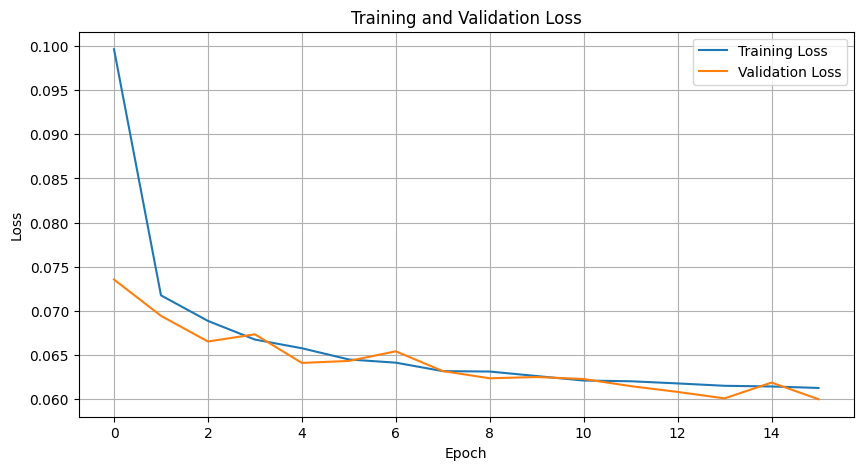


Epoch 17/30
--------------------
  Step 0/750, Loss: 0.0595
  Step 100/750, Loss: 0.0593
  Step 200/750, Loss: 0.0601
  Step 300/750, Loss: 0.0587
  Step 400/750, Loss: 0.0626
  Step 500/750, Loss: 0.0677
  Generating samples...


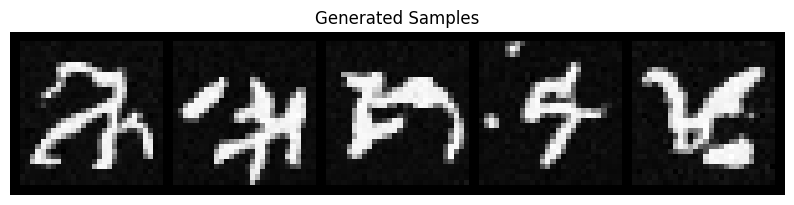

  Step 600/750, Loss: 0.0496
  Step 700/750, Loss: 0.0584

Training - Epoch 17 average loss: 0.0610
Running validation...
Validation - Epoch 17 average loss: 0.0606
Current learning rate: 0.001000

Generating samples for visual progress check...


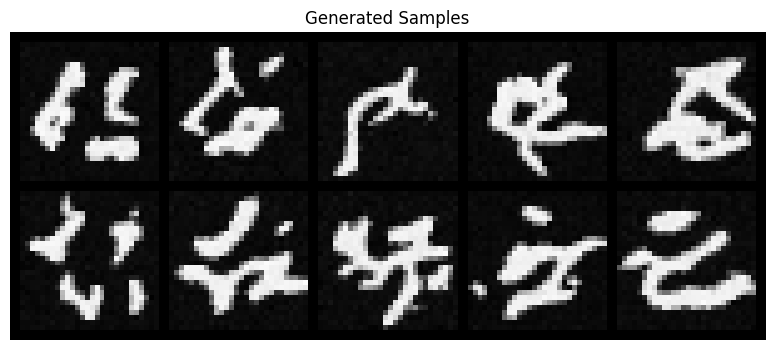

No improvement for 1/10 epochs.

Epoch 18/30
--------------------
  Step 0/750, Loss: 0.0644
  Step 100/750, Loss: 0.0617
  Step 200/750, Loss: 0.0563
  Step 300/750, Loss: 0.0594
  Step 400/750, Loss: 0.0575
  Step 500/750, Loss: 0.0579
  Generating samples...


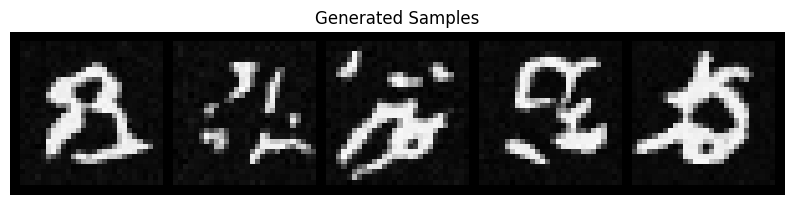

  Step 600/750, Loss: 0.0603
  Step 700/750, Loss: 0.0606

Training - Epoch 18 average loss: 0.0607
Running validation...
Validation - Epoch 18 average loss: 0.0608
Current learning rate: 0.001000
No improvement for 2/10 epochs.

Epoch 19/30
--------------------
  Step 0/750, Loss: 0.0719
  Step 100/750, Loss: 0.0570
  Step 200/750, Loss: 0.0664
  Step 300/750, Loss: 0.0702
  Step 400/750, Loss: 0.0607
  Step 500/750, Loss: 0.0548
  Generating samples...


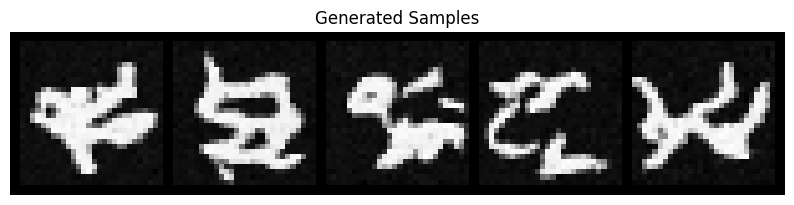

  Step 600/750, Loss: 0.0691
  Step 700/750, Loss: 0.0660

Training - Epoch 19 average loss: 0.0608
Running validation...
Validation - Epoch 19 average loss: 0.0608
Current learning rate: 0.001000

Generating samples for visual progress check...


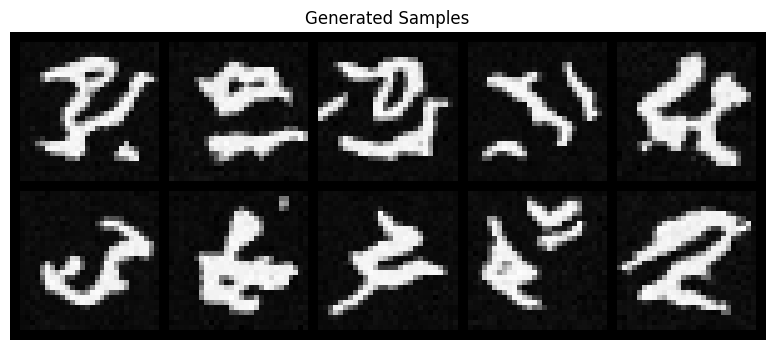

No improvement for 3/10 epochs.

Epoch 20/30
--------------------
  Step 0/750, Loss: 0.0589
  Step 100/750, Loss: 0.0576
  Step 200/750, Loss: 0.0558
  Step 300/750, Loss: 0.0607
  Step 400/750, Loss: 0.0618
  Step 500/750, Loss: 0.0613
  Generating samples...


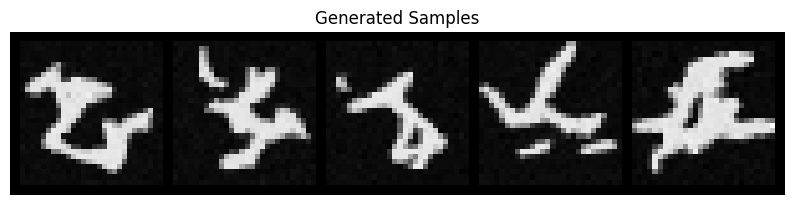

  Step 600/750, Loss: 0.0670
  Step 700/750, Loss: 0.0669

Training - Epoch 20 average loss: 0.0604
Running validation...
Validation - Epoch 20 average loss: 0.0602
Current learning rate: 0.001000
No improvement for 4/10 epochs.

Epoch 21/30
--------------------
  Step 0/750, Loss: 0.0579
  Step 100/750, Loss: 0.0710
  Step 200/750, Loss: 0.0655
  Step 300/750, Loss: 0.0511
  Step 400/750, Loss: 0.0577
  Step 500/750, Loss: 0.0632
  Generating samples...


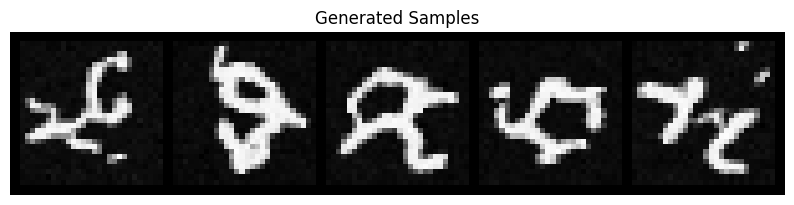

  Step 600/750, Loss: 0.0624
  Step 700/750, Loss: 0.0560

Training - Epoch 21 average loss: 0.0609
Running validation...
Validation - Epoch 21 average loss: 0.0591
Current learning rate: 0.001000

Generating samples for visual progress check...


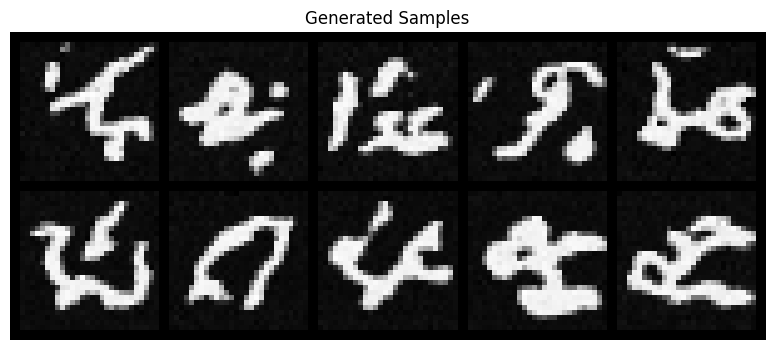

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0591)


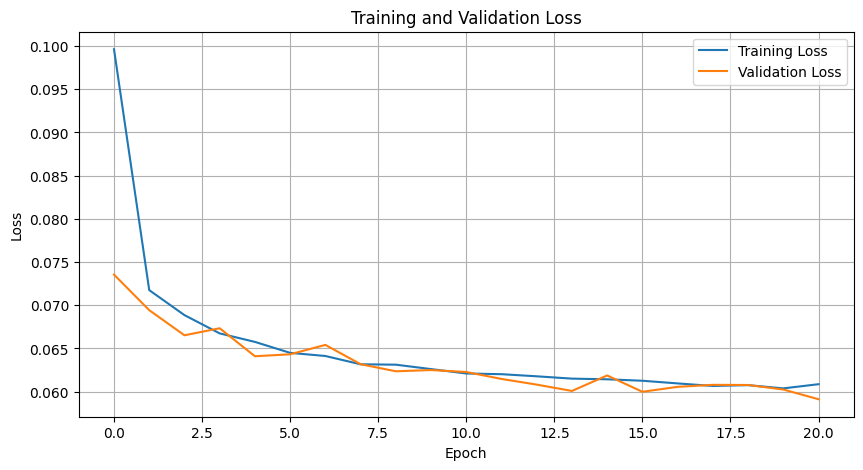


Epoch 22/30
--------------------
  Step 0/750, Loss: 0.0628
  Step 100/750, Loss: 0.0715
  Step 200/750, Loss: 0.0539
  Step 300/750, Loss: 0.0613
  Step 400/750, Loss: 0.0600
  Step 500/750, Loss: 0.0580
  Generating samples...


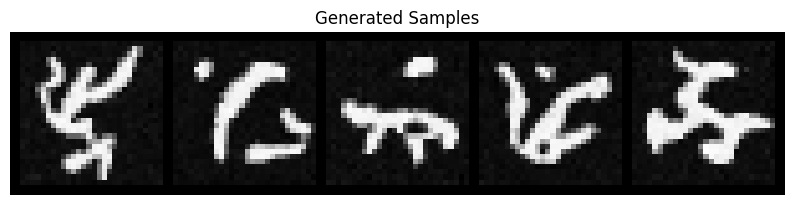

  Step 600/750, Loss: 0.0604
  Step 700/750, Loss: 0.0634

Training - Epoch 22 average loss: 0.0601
Running validation...
Validation - Epoch 22 average loss: 0.0603
Current learning rate: 0.001000
No improvement for 1/10 epochs.

Epoch 23/30
--------------------
  Step 0/750, Loss: 0.0576
  Step 100/750, Loss: 0.0597
  Step 200/750, Loss: 0.0583
  Step 300/750, Loss: 0.0712
  Step 400/750, Loss: 0.0550
  Step 500/750, Loss: 0.0633
  Generating samples...


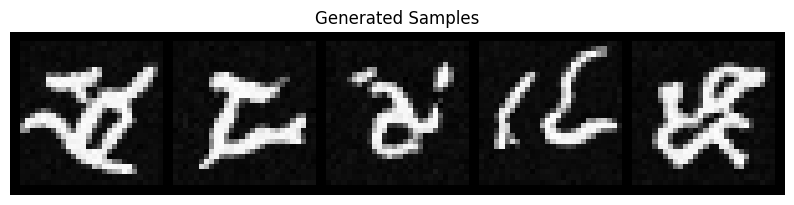

  Step 600/750, Loss: 0.0698
  Step 700/750, Loss: 0.0555

Training - Epoch 23 average loss: 0.0598
Running validation...
Validation - Epoch 23 average loss: 0.0599
Current learning rate: 0.001000

Generating samples for visual progress check...


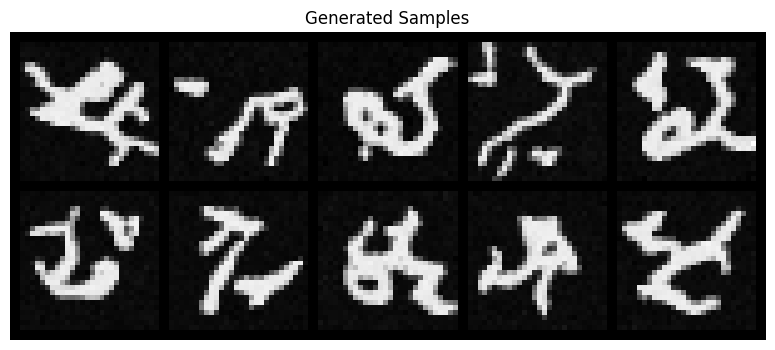

No improvement for 2/10 epochs.

Epoch 24/30
--------------------
  Step 0/750, Loss: 0.0602
  Step 100/750, Loss: 0.0631
  Step 200/750, Loss: 0.0572
  Step 300/750, Loss: 0.0646
  Step 400/750, Loss: 0.0601
  Step 500/750, Loss: 0.0541
  Generating samples...


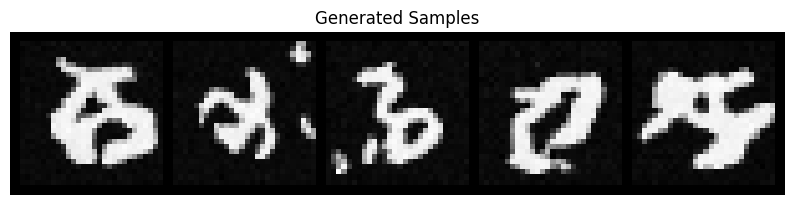

  Step 600/750, Loss: 0.0610
  Step 700/750, Loss: 0.0645

Training - Epoch 24 average loss: 0.0600
Running validation...
Validation - Epoch 24 average loss: 0.0599
Current learning rate: 0.001000
No improvement for 3/10 epochs.

Epoch 25/30
--------------------
  Step 0/750, Loss: 0.0549
  Step 100/750, Loss: 0.0554
  Step 200/750, Loss: 0.0640
  Step 300/750, Loss: 0.0609
  Step 400/750, Loss: 0.0610
  Step 500/750, Loss: 0.0627
  Generating samples...


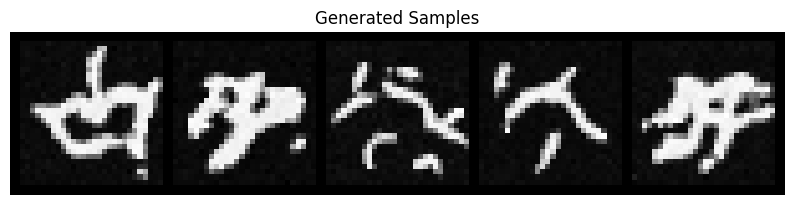

  Step 600/750, Loss: 0.0591
  Step 700/750, Loss: 0.0578

Training - Epoch 25 average loss: 0.0599
Running validation...
Validation - Epoch 25 average loss: 0.0591
Current learning rate: 0.001000

Generating samples for visual progress check...


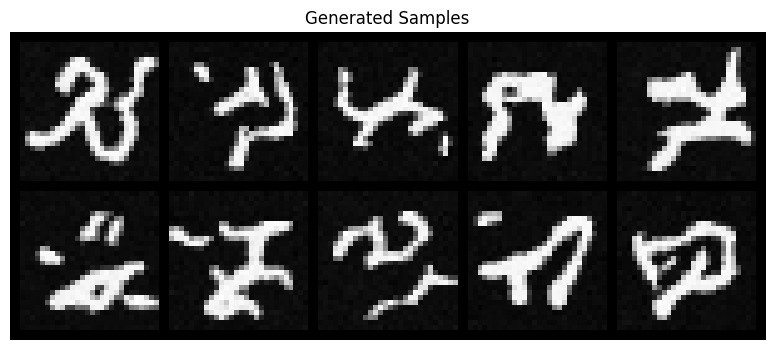

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0591)

Epoch 26/30
--------------------
  Step 0/750, Loss: 0.0632
  Step 100/750, Loss: 0.0583
  Step 200/750, Loss: 0.0654
  Step 300/750, Loss: 0.0609
  Step 400/750, Loss: 0.0615
  Step 500/750, Loss: 0.0622
  Generating samples...


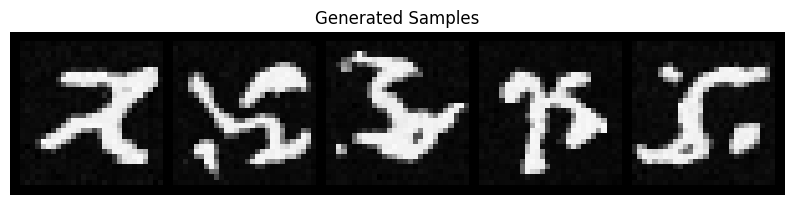

  Step 600/750, Loss: 0.0581
  Step 700/750, Loss: 0.0611

Training - Epoch 26 average loss: 0.0598
Running validation...
Validation - Epoch 26 average loss: 0.0591
Current learning rate: 0.001000
No improvement for 1/10 epochs.


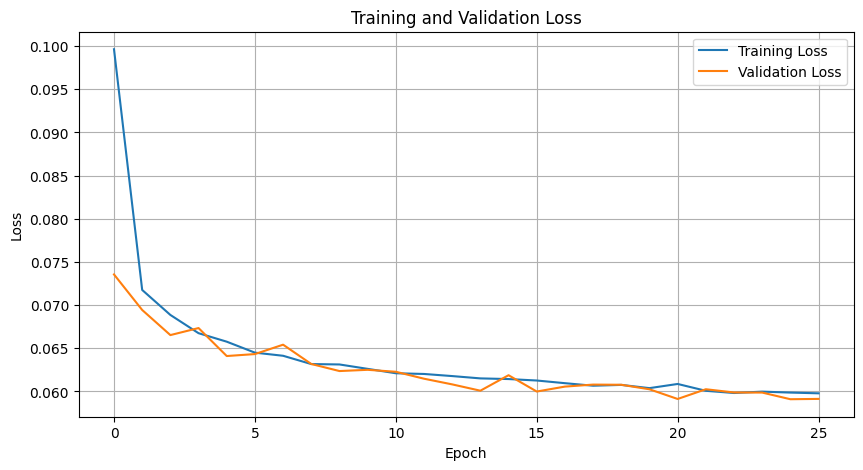


Epoch 27/30
--------------------
  Step 0/750, Loss: 0.0653
  Step 100/750, Loss: 0.0598
  Step 200/750, Loss: 0.0520
  Step 300/750, Loss: 0.0586
  Step 400/750, Loss: 0.0598
  Step 500/750, Loss: 0.0554
  Generating samples...


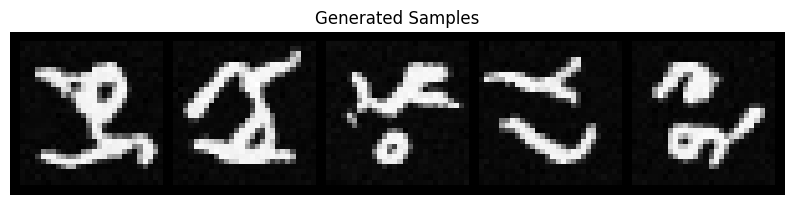

  Step 600/750, Loss: 0.0543
  Step 700/750, Loss: 0.0652

Training - Epoch 27 average loss: 0.0598
Running validation...
Validation - Epoch 27 average loss: 0.0595
Current learning rate: 0.001000

Generating samples for visual progress check...


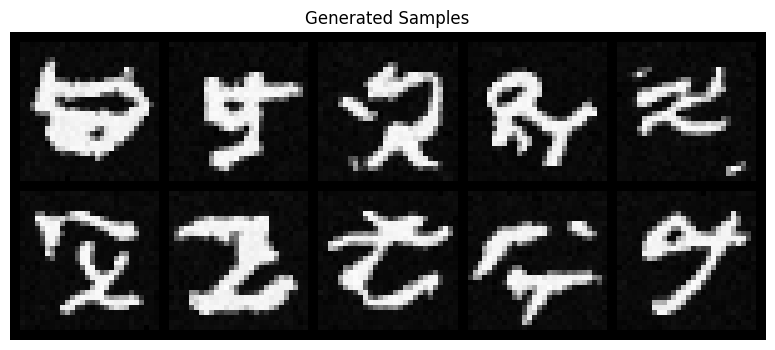

No improvement for 2/10 epochs.

Epoch 28/30
--------------------
  Step 0/750, Loss: 0.0566
  Step 100/750, Loss: 0.0617
  Step 200/750, Loss: 0.0572
  Step 300/750, Loss: 0.0562
  Step 400/750, Loss: 0.0613
  Step 500/750, Loss: 0.0578
  Generating samples...


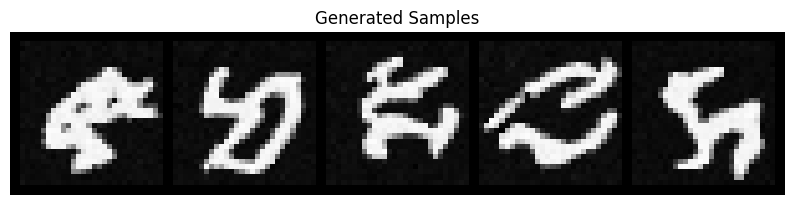

  Step 600/750, Loss: 0.0605
  Step 700/750, Loss: 0.0612

Training - Epoch 28 average loss: 0.0595
Running validation...
Validation - Epoch 28 average loss: 0.0588
Current learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Validation Loss: 0.0588)

Epoch 29/30
--------------------
  Step 0/750, Loss: 0.0614
  Step 100/750, Loss: 0.0591
  Step 200/750, Loss: 0.0598
  Step 300/750, Loss: 0.0691
  Step 400/750, Loss: 0.0558
  Step 500/750, Loss: 0.0625
  Generating samples...


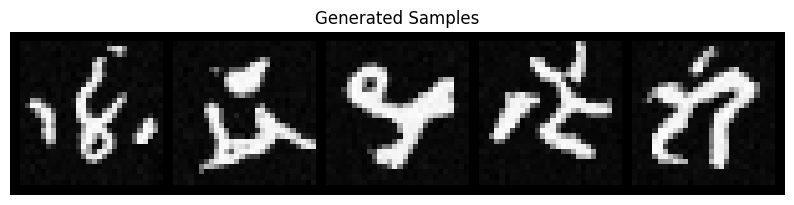

  Step 600/750, Loss: 0.0558
  Step 700/750, Loss: 0.0577

Training - Epoch 29 average loss: 0.0596
Running validation...
Validation - Epoch 29 average loss: 0.0592
Current learning rate: 0.001000

Generating samples for visual progress check...


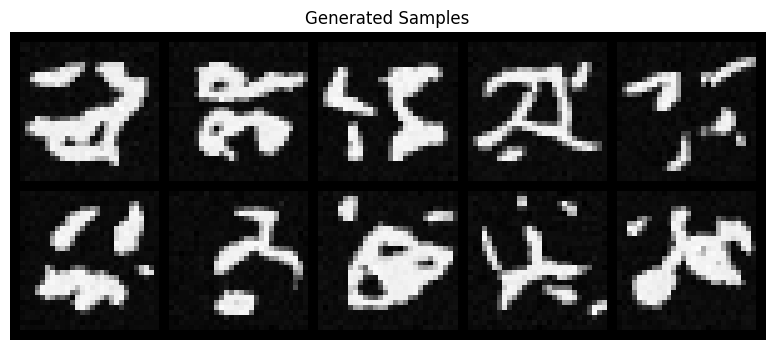

No improvement for 1/10 epochs.

Epoch 30/30
--------------------
  Step 0/750, Loss: 0.0681
  Step 100/750, Loss: 0.0667
  Step 200/750, Loss: 0.0582
  Step 300/750, Loss: 0.0610
  Step 400/750, Loss: 0.0698
  Step 500/750, Loss: 0.0551
  Generating samples...


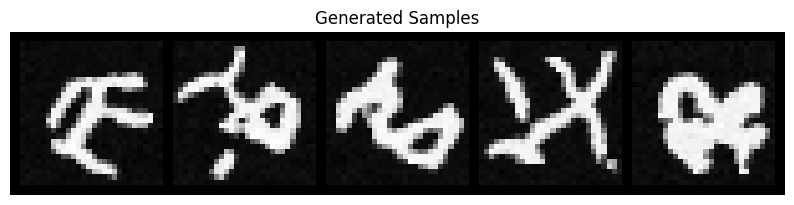

  Step 600/750, Loss: 0.0530
  Step 700/750, Loss: 0.0577

Training - Epoch 30 average loss: 0.0596
Running validation...
Validation - Epoch 30 average loss: 0.0592
Current learning rate: 0.001000

Generating samples for visual progress check...


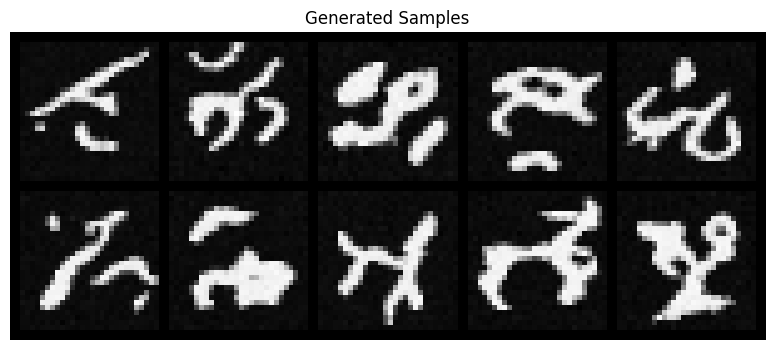

No improvement for 2/10 epochs.


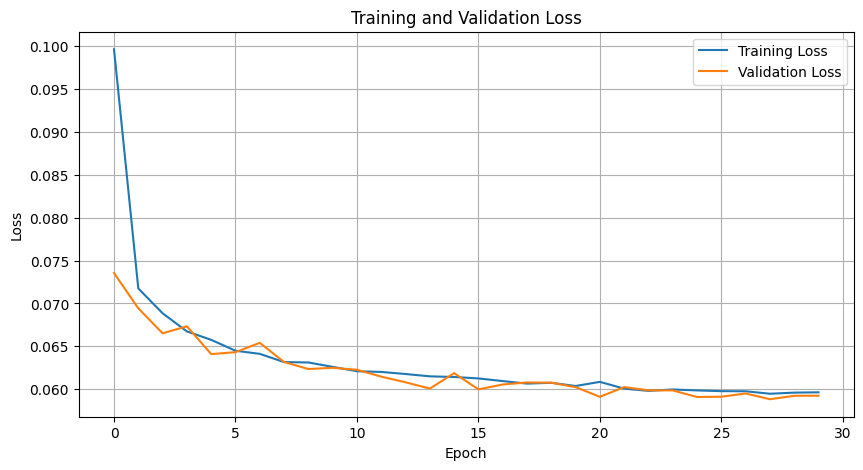


TRAINING COMPLETE OR STOPPED
Best validation loss achieved: 0.0588
Generating final samples...


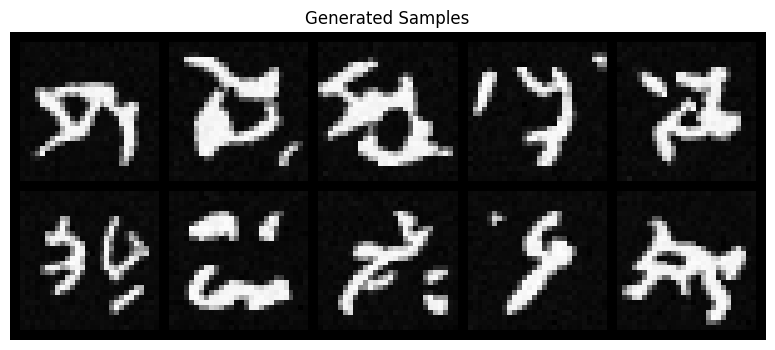

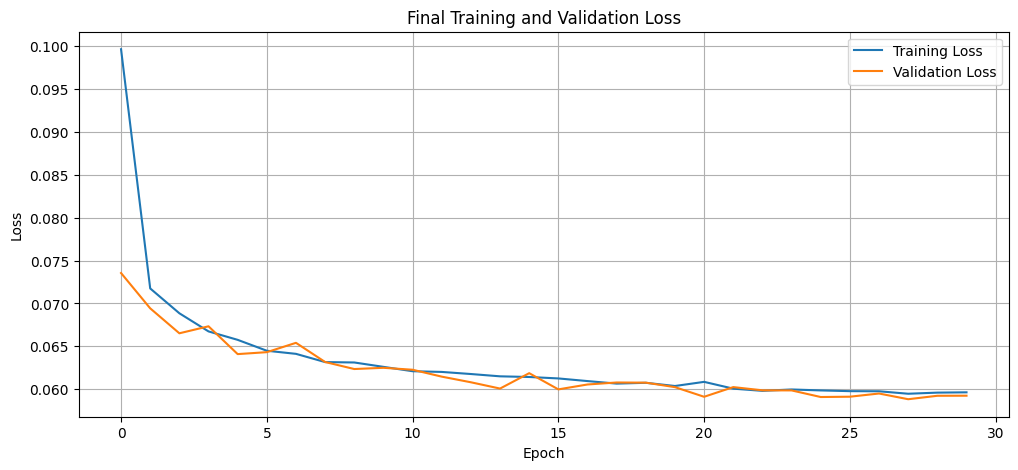

Cleaning up GPU memory...


In [45]:
# Implementation of the main training loop

# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

# Wrap the training loop in a try-except block for better error handling
try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # --- Training phase ---
        model.train()
        epoch_losses = []

        # Process each batch in the training data
        for step, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # --- Single training step ---
            optimizer.zero_grad()
            loss = train_step(images, labels) # This function was defined in the previous cell
            loss.backward()

            # Clip gradients to prevent exploding gradients, a common issue in deep networks
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time and check progress
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5)

        # --- End of epoch training summary ---
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # --- Validation phase ---
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation to save memory and computation
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss using the same step function
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # --- End of epoch validation summary ---
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr:.6f}")

        # Generate a larger set of samples at the end of each epoch for visual inspection
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10)

        # --- Save the best model ---
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
            print(f"✓ New best model saved! (Validation Loss: {best_loss:.4f})")
            no_improve_epochs = 0 # Reset counter on improvement
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs.")

        # --- Early stopping ---
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs to monitor training
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc()
finally:
    # --- Final wrap-up ---
    print("\n" + "="*50)
    print("TRAINING COMPLETE OR STOPPED")
    print("="*50)
    print(f"Best validation loss achieved: {best_loss:.4f}")

    # Generate final samples from the last state of the model
    print("Generating final samples...")
    generate_samples(model, n_samples=10)

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up GPU memory
    print("Cleaning up GPU memory...")
    torch.cuda.empty_cache()

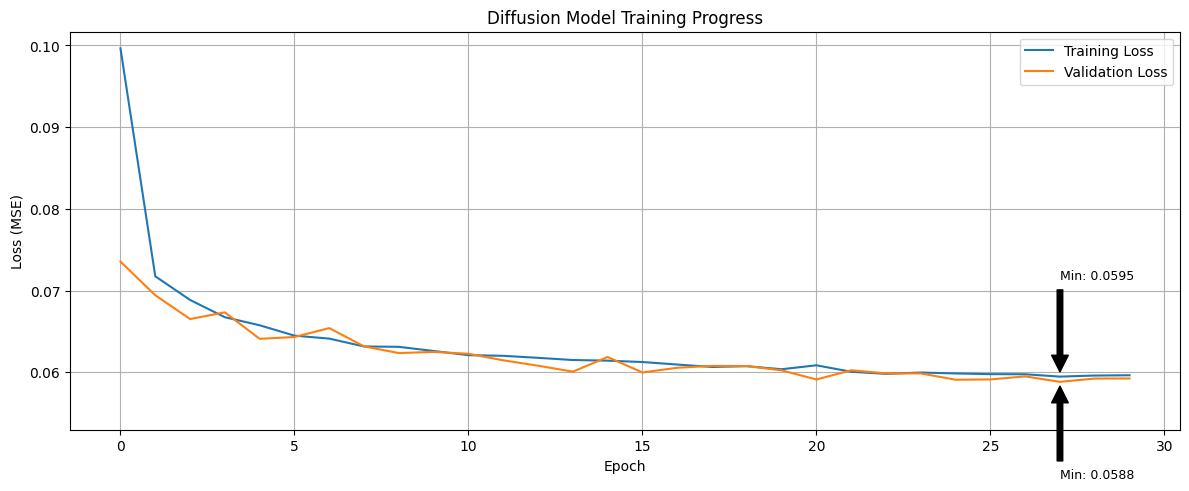


Training Statistics:
------------------------------
Starting training loss:    0.0996
Final training loss:       0.0596
Best training loss:        0.0595
Training loss improvement: 40.3%

Validation Statistics:
------------------------------
Starting validation loss: 0.0735
Final validation loss:    0.0592
Best validation loss:     0.0588


In [46]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 1...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 2...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 3...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed
Generating 4 versions of number 4...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 

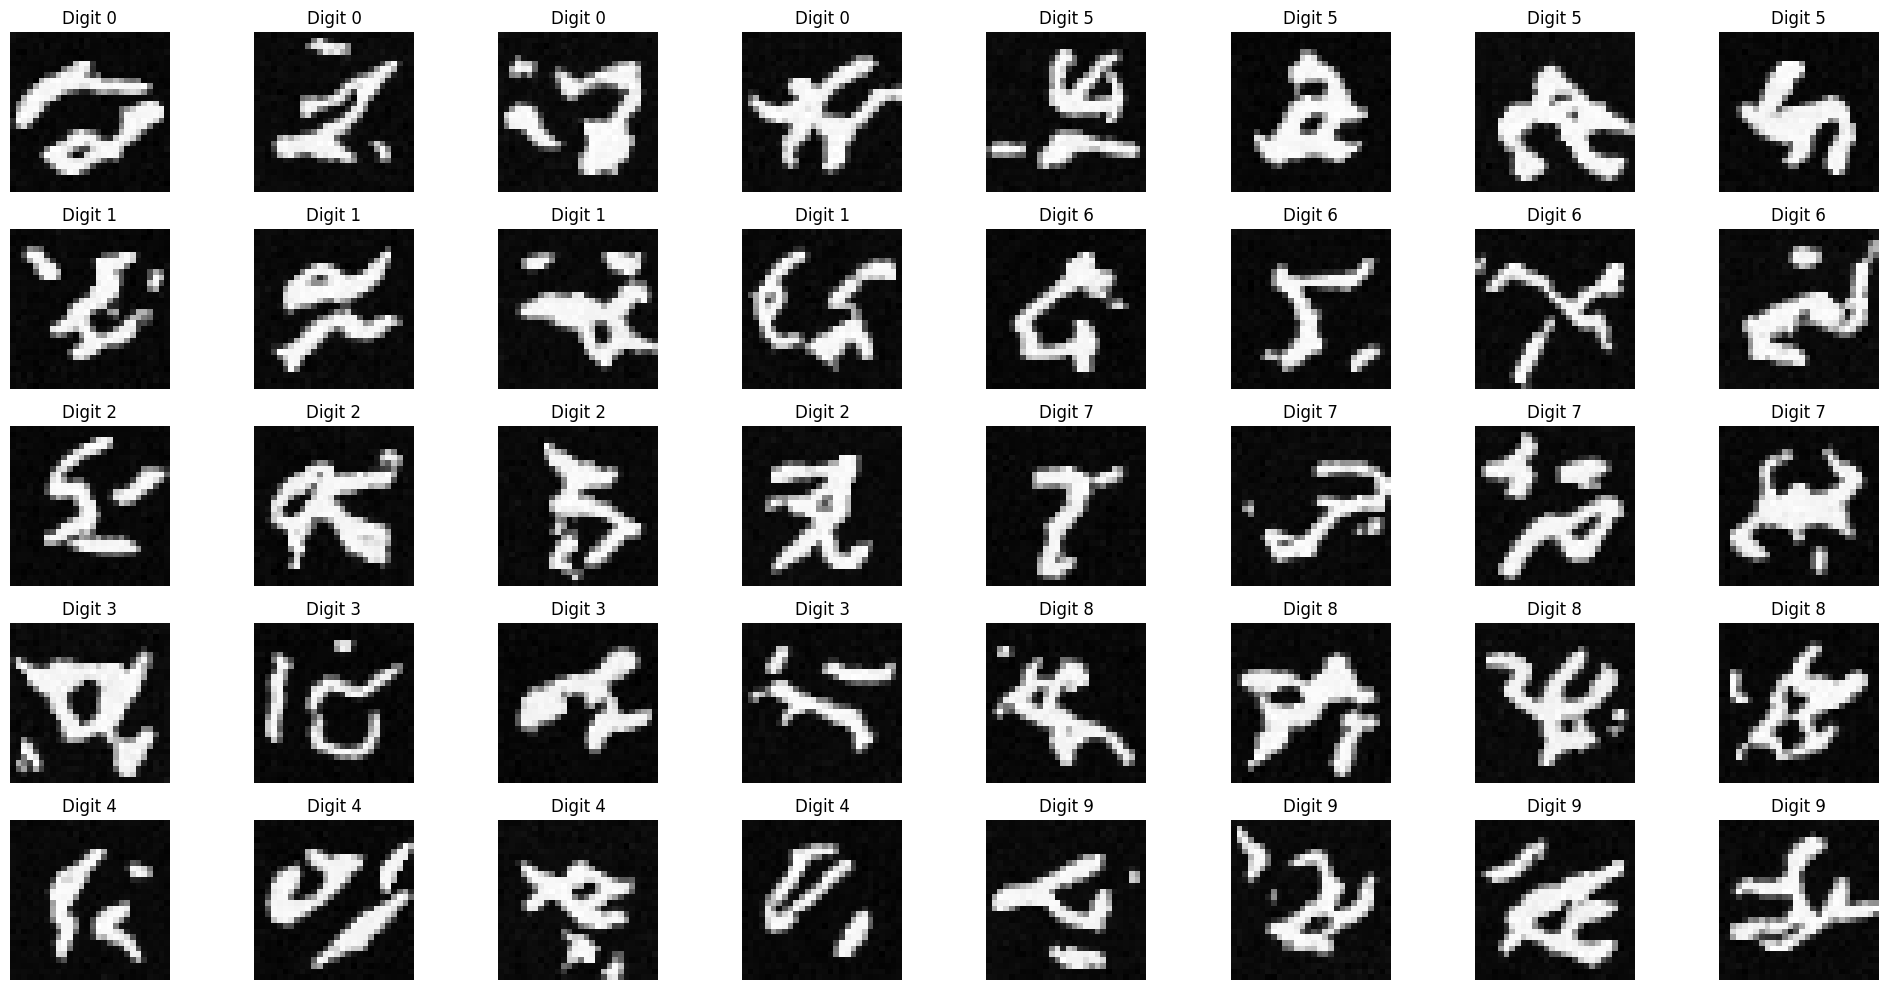


STUDENT ACTIVITY: Generating numbers with different noise seeds

Generating 10 different styles of the digit '7'...
Generating 10 versions of number 7...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


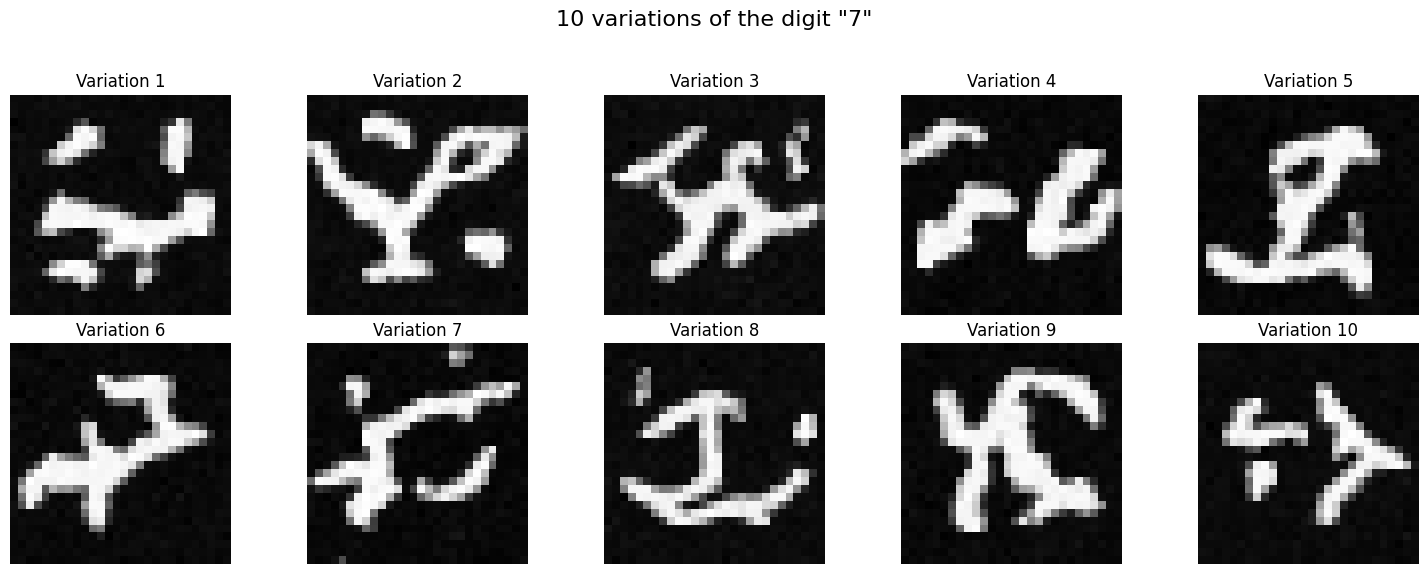

In [50]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(model, i, n_samples=4)

    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)

        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)

        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a image and show many variations
# Hint select a image e.g. dog  # Change this to any other in the dataset of subset you chose
# Hint 2 use variations = generate_with_seed
# Hint 3 use plt.figure and plt.imshow to display the variations

# Enter your code here:

digit_to_show = 7
num_variations = 10

print(f"\nGenerating {num_variations} different styles of the digit '{digit_to_show}'...")
variations = generate_with_seed(digit_to_show, seed_value=123, n_samples=num_variations)

plt.figure(figsize=(15, 6))
plt.suptitle(f'{num_variations} variations of the digit "{digit_to_show}"', fontsize=16)

for i in range(num_variations):
    plt.subplot(2, 5, i + 1)
    if IMG_CH == 1:
        plt.imshow(variations[i][0].cpu(), cmap='gray')
    else:
        img = variations[i].permute(1, 2, 0).cpu()
        if img.min() < 0:
            img = (img + 1) / 2
        plt.imshow(img)
    plt.title(f'Variation {i+1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Visualizing denoising process for digit 3:


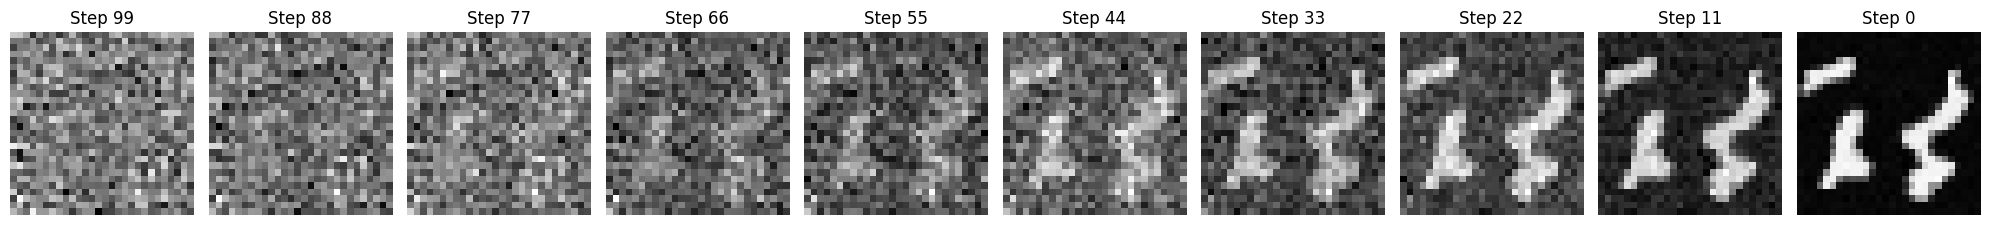


Visualizing denoising process for digit 7:


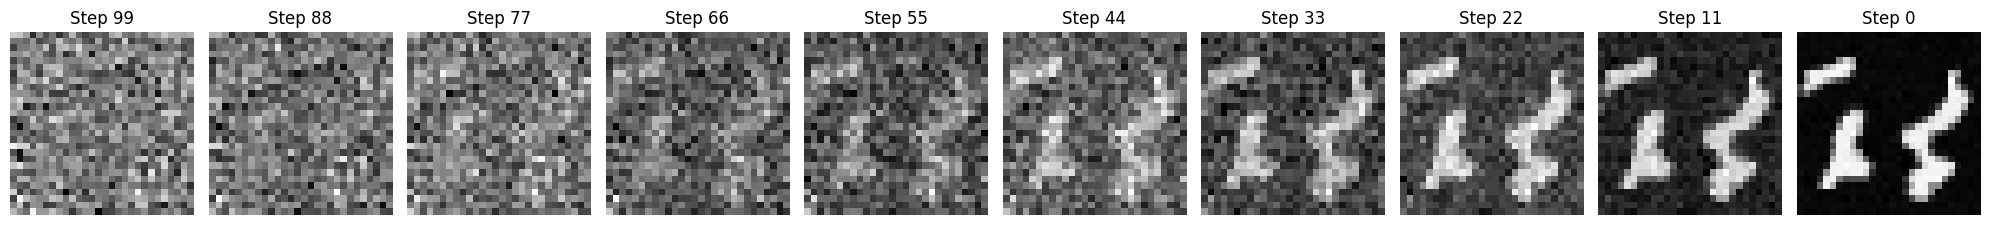


Visualizing denoising process for digit 9:


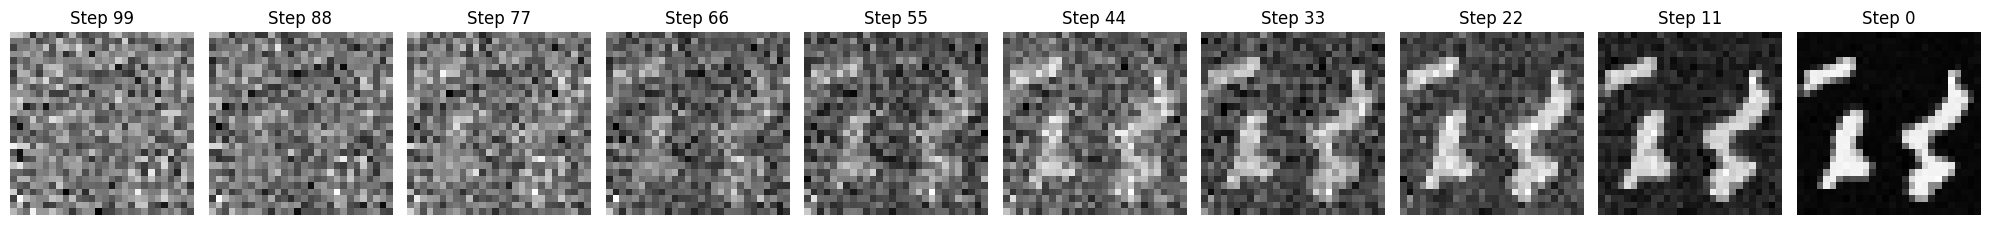

In [52]:
def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Shows how an image evolves from pure noise to a clear digit,
    displaying intermediate steps of the denoising process.

    Args:
        model (nn.Module): The trained diffusion model.
        number (int): The digit to generate (0-9).
        n_preview_steps (int): The number of intermediate steps to show.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():  # Disable gradient calculations for efficiency
        # Start with a single, reproducible noise sample for consistent visualization
        torch.manual_seed(42)
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # 1. Create the class label tensor
        c = torch.tensor([number]).to(device) # Shape: [1]

        # 2. Convert to one-hot encoding for the model
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device) # Shape: [1, 10]

        # 3. FIX: Create a correctly shaped conditioning mask.
        c_mask = torch.ones(x.shape[0], 1).to(device) # Shape: [1, 1]

        # --- Visualization setup ---
        images = []  # To store images at different stages
        # Determine which specific timesteps to capture for the preview
        steps_to_show = torch.linspace(0, n_steps - 1, n_preview_steps, dtype=torch.long).flip(0)

        print(f"\nVisualizing denoising process for digit {number}:")

        # Loop backwards from the noisiest step (n_steps-1) to the clear image (step 0)
        for t_val in range(n_steps - 1, -1, -1):
            t_batch = torch.full((1,), t_val).to(device)

            # Perform one step of the reverse diffusion process
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            # If the current step is one we want to preview, save the image
            if t_val in steps_to_show:
                images.append(x[0].cpu())

        # Plot the captured images in a grid
        plt.figure(figsize=(20, 4))
        for i, img in enumerate(images):
            ax = plt.subplot(1, n_preview_steps, i + 1)

            # Display image, handling grayscale/color and normalization
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img_display = img.permute(1, 2, 0)
                if img_display.min() < 0:
                    img_display = (img_display + 1) / 2
                plt.imshow(img_display)

            plt.title(f'Step {steps_to_show[i].item()}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Show the step-by-step generation process for a few example numbers
for number_to_viz in [3, 7, 9]:
    visualize_generation_steps(model, number_to_viz)

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [53]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [54]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
Generating 4 versions of number 0...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


/tmp/ipython-input-56-1990899663.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


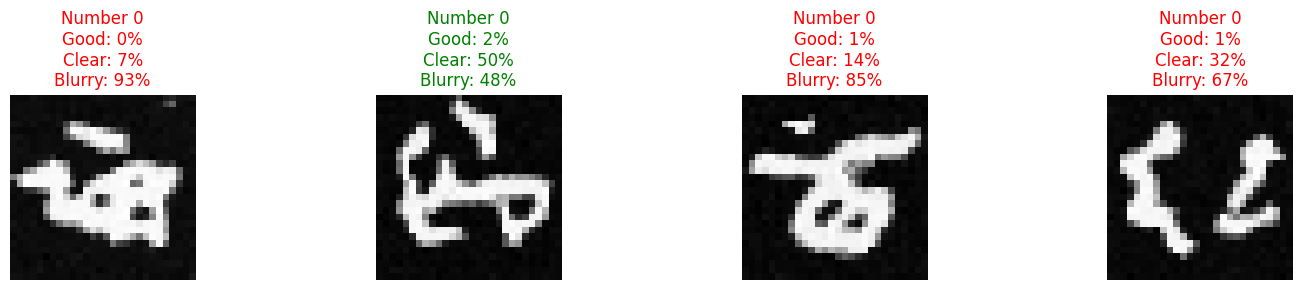


Generating and evaluating number 1...
Generating 4 versions of number 1...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


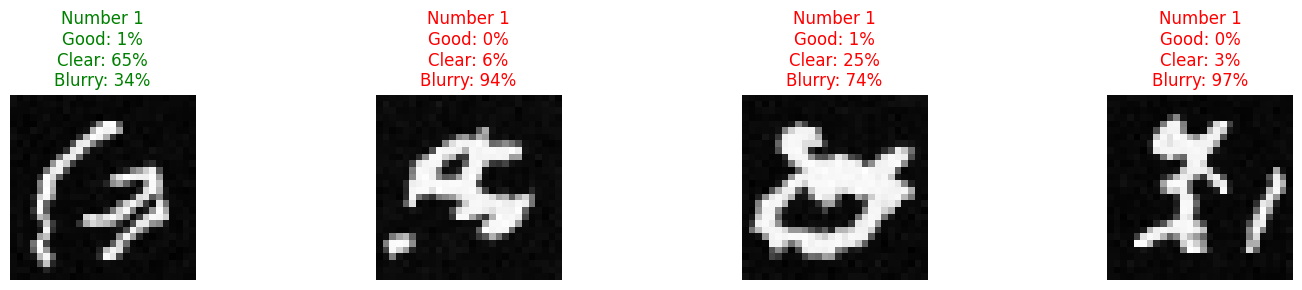


Generating and evaluating number 2...
Generating 4 versions of number 2...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


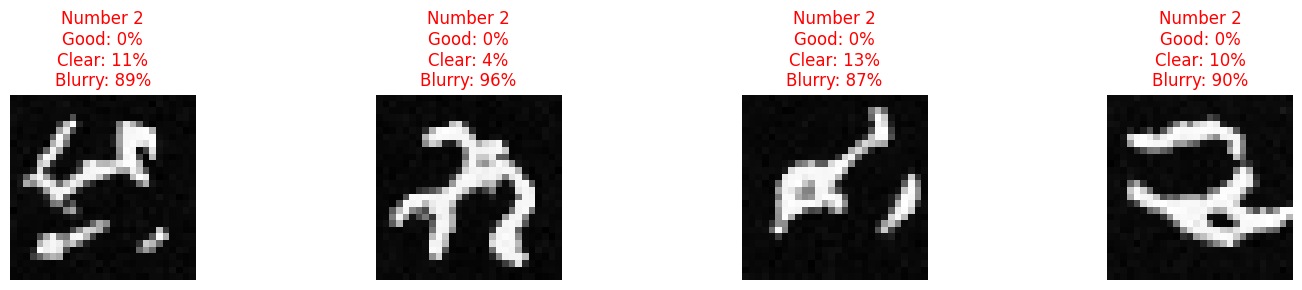


Generating and evaluating number 3...
Generating 4 versions of number 3...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


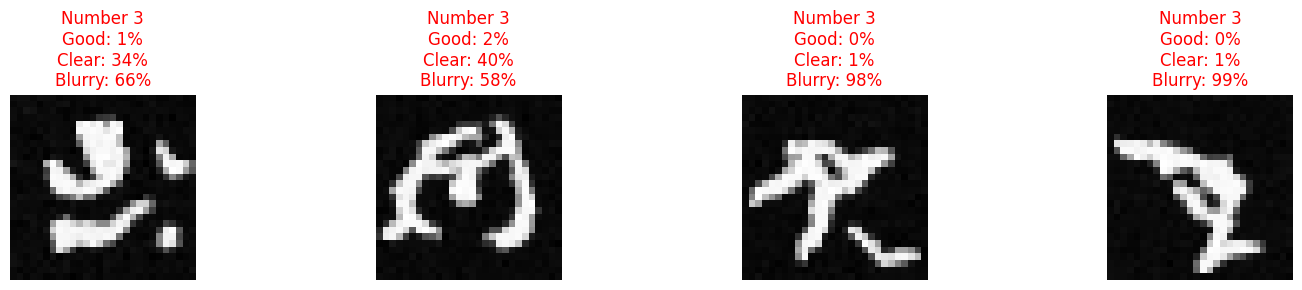


Generating and evaluating number 4...
Generating 4 versions of number 4...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


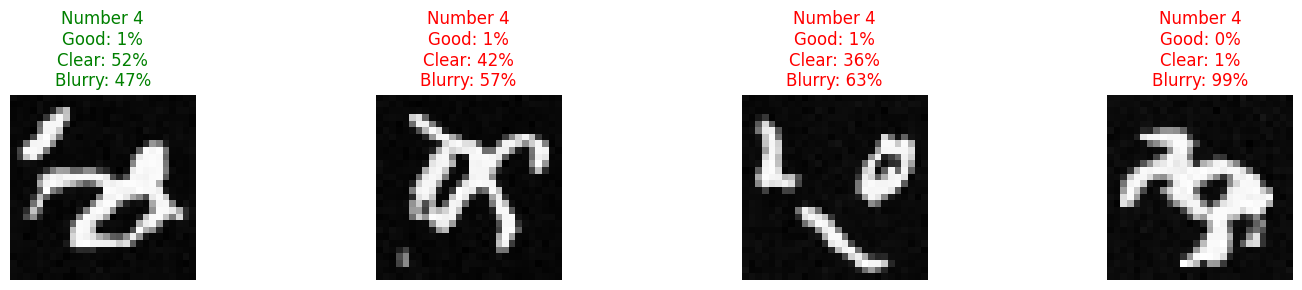


Generating and evaluating number 5...
Generating 4 versions of number 5...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


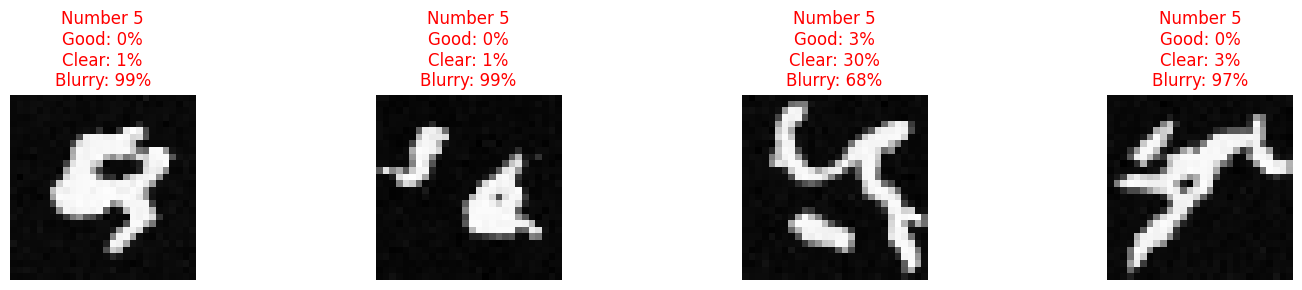


Generating and evaluating number 6...
Generating 4 versions of number 6...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


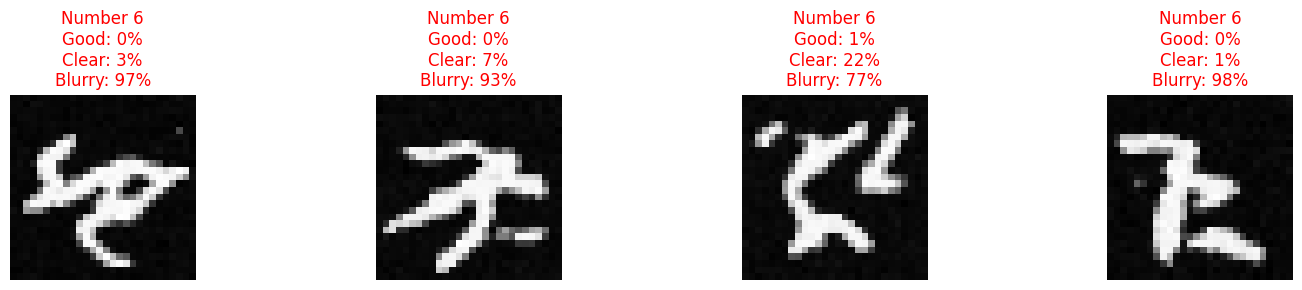


Generating and evaluating number 7...
Generating 4 versions of number 7...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


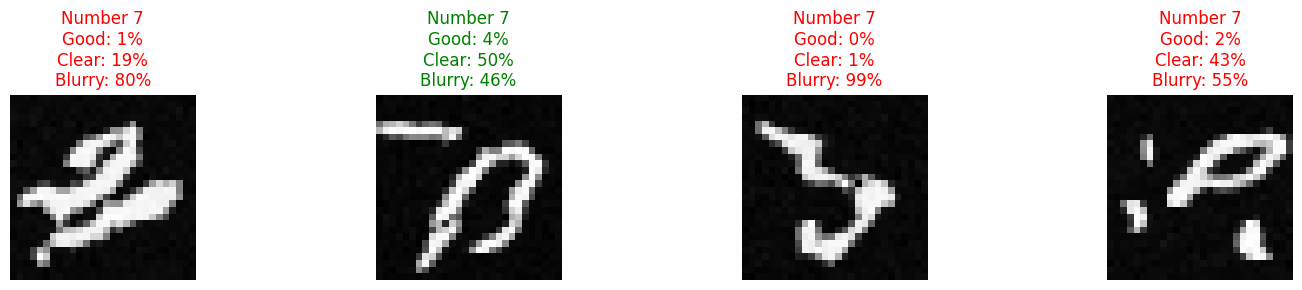


Generating and evaluating number 8...
Generating 4 versions of number 8...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


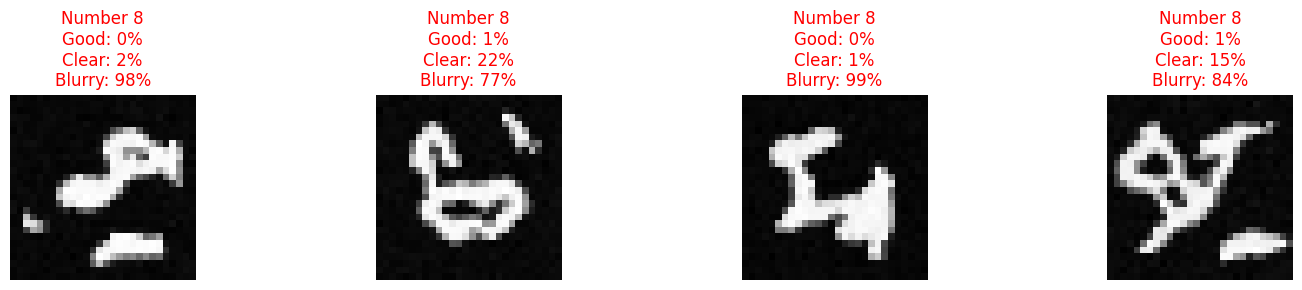


Generating and evaluating number 9...
Generating 4 versions of number 9...
  Denoising step 19/99 completed
  Denoising step 39/99 completed
  Denoising step 59/99 completed
  Denoising step 79/99 completed
  Denoising step 99/99 completed


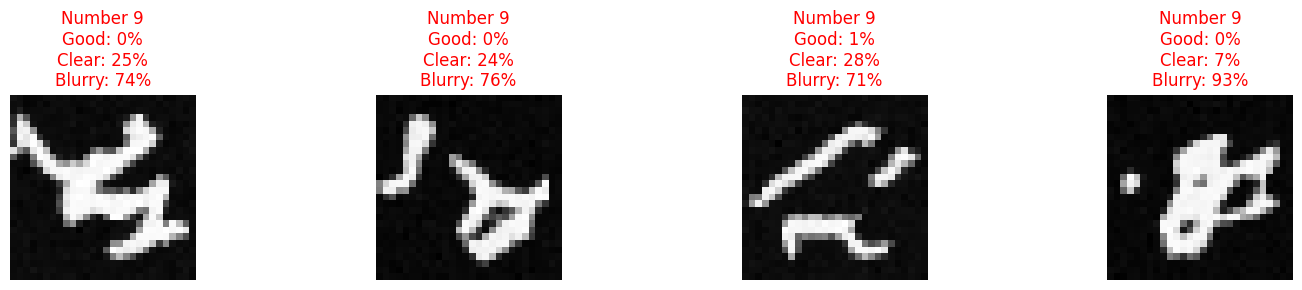

In [56]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges